Load Packages

In [ ]:

!pip install datasets matplotlib seaborn nltk wordcloud scikit-learn spacy contractions sentencepiece hmmlearn

!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0

In [ ]:

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from wordcloud import WordCloud
from nltk.util import ngrams
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import contractions
import sentencepiece as spm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from hmmlearn import hmm



Load the data

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
from datasets import load_dataset

opus_dataset = load_dataset("opus_books", "en-fr")

print(opus_dataset)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 127085
    })
})


Sample the data

In [ ]:

opus_data = opus_dataset["train"].train_test_split(test_size=0.1, seed=7)["test"]  # 10% data

print(f"Total original dataset size: {len(opus_dataset['train'])}")
print(f"Sampled dataset size: {len(opus_data)}")




Total original dataset size: 127085
Sampled dataset size: 12709


In [ ]:
for i in range(10):
    print(opus_data[i])

{'id': '17896', 'translation': {'en': 'I lived six years in this happy but unhappy condition, in which time I brought him three children, but only the first of them lived; and though I removed twice in those six years, yet I came back the sixth year to my first lodgings at Hammersmith.', 'fr': 'Je vécus six ans dans cette condition, tout ensemble heureuse et infortunée, pendant lequel temps je lui donnai trois enfants; mais le premier seul vécut; et quoique ayant déménagé deux fois pendant ces six années, pourtant la sixième je retournai dans mon premier logement à Hammersmith.'}}
{'id': '25216', 'translation': {'en': 'Then when the infantry had formed in long deep masses their guns came whirling and bounding down the slope, and it was pretty to see how smartly they unlimbered and were ready for action.', 'fr': "Puis, lorsque l'infanterie se fut formée en masses longues et profondes, leurs canons arrivèrent en bondissant et tournant le long de la pente. Rien de plus joli à voir que la 

Data Preprocessing

In [ ]:
print(type(opus_data))  # Check data types


<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
#converting into data frame
df = pd.DataFrame(opus_data)

df.head(5)


,id,translation
0,17896,{'en': 'I lived six years in this happy but un...
1,25216,{'en': 'Then when the infantry had formed in l...
2,1928,"{'en': 'We had just finished examinations.', '..."
3,107345,"{'en': '""To a tailor's.""', 'fr': '-- Chez un m..."
4,76726,"{'en': '– Il faut convenir, mon pauvre Gonzo, ..."


In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12709 entries, 0 to 12708
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           12709 non-null  object
 1   translation  12709 non-null  object
dtypes: object(2)
memory usage: 198.7+ KB
None


In [ ]:
# Extract 'en' and 'fr' from the 'translation' column
df['en'] = df['translation'].apply(lambda x: x['en'])
df['fr'] = df['translation'].apply(lambda x: x['fr'])

# Drop the original 'translation' column
df = df.drop(columns=['translation'])

print(df.head())


       id                                                 en  \
0   17896  I lived six years in this happy but unhappy co...   
1   25216  Then when the infantry had formed in long deep...   
2    1928                 We had just finished examinations.   
3  107345                                   "To a tailor's."   
4   76726  – Il faut convenir, mon pauvre Gonzo, que vous...   

                                                  fr  
0  Je vécus six ans dans cette condition, tout en...  
1  Puis, lorsque l'infanterie se fut formée en ma...  
2                Nous venions de passer les examens.  
3               -- Chez un marchand de confection. »  
4  "You must agree, my poor Gonzo, that your tact...  


In [ ]:
# Check the data types and non-null counts
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12709 entries, 0 to 12708
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      12709 non-null  object
 1   en      12709 non-null  object
 2   fr      12709 non-null  object
dtypes: object(3)
memory usage: 298.0+ KB
None


In [ ]:

total_sentences = len(df)
print(f"Total number of sentence pairs: {total_sentences}")


df['en_length'] = df['en'].apply(lambda x: len(x.split()))
df['fr_length'] = df['fr'].apply(lambda x: len(x.split()))

avg_en_length = df['en_length'].mean()
avg_fr_length = df['fr_length'].mean()

print(f"Average sentence length in English: {avg_en_length}")
print(f"Average sentence length in French: {avg_fr_length}")


longest_en = df.loc[df['en_length'].idxmax()]['en']
shortest_en = df.loc[df['en_length'].idxmin()]['en']

longest_fr = df.loc[df['fr_length'].idxmax()]['fr']
shortest_fr = df.loc[df['fr_length'].idxmin()]['fr']

print(f"Longest English sentence: {longest_en}")
print("length of english sentence", len(longest_en))
print(f"Shortest English sentence: {shortest_en}")
print(f"Longest French sentence: {longest_fr}")
print("length of longest French sentence", len(longest_fr))
print(f"Shortest French sentence: {shortest_fr}")


Total number of sentence pairs: 12709
Average sentence length in English: 21.25226217641042
Average sentence length in French: 20.67763002596585
Longest English sentence: I had, God knows, more sincerity than knowledge in all the methods I took for this poor creature’s instruction, and must acknowledge, what I believe all that act upon the same principle will find, that in laying things open to him, I really informed and instructed myself in many things that either I did not know or had not fully considered before, but which occurred naturally to my mind upon searching into them, for the information of this poor savage; and I had more affection in my inquiry after things upon this occasion than ever I felt before: so that, whether this poor wild wretch was better for me or no, I had great reason to be thankful that ever he came to me; my grief sat lighter, upon me; my habitation grew comfortable to me beyond measure: and when I reflected that in this solitary life which I have been con

Most common English words: [('the', 13566), ('of', 7102), ('to', 6976), ('and', 6541), ('a', 5352), ('I', 3804), ('in', 3746), ('was', 3392), ('that', 2811), ('he', 2453)]
Most common French words: [('de', 10056), ('la', 5698), ('et', 5460), ('le', 4703), ('à', 4007), ('que', 3325), ('les', 3155), ('un', 2452), ('en', 2284), ('je', 2190)]


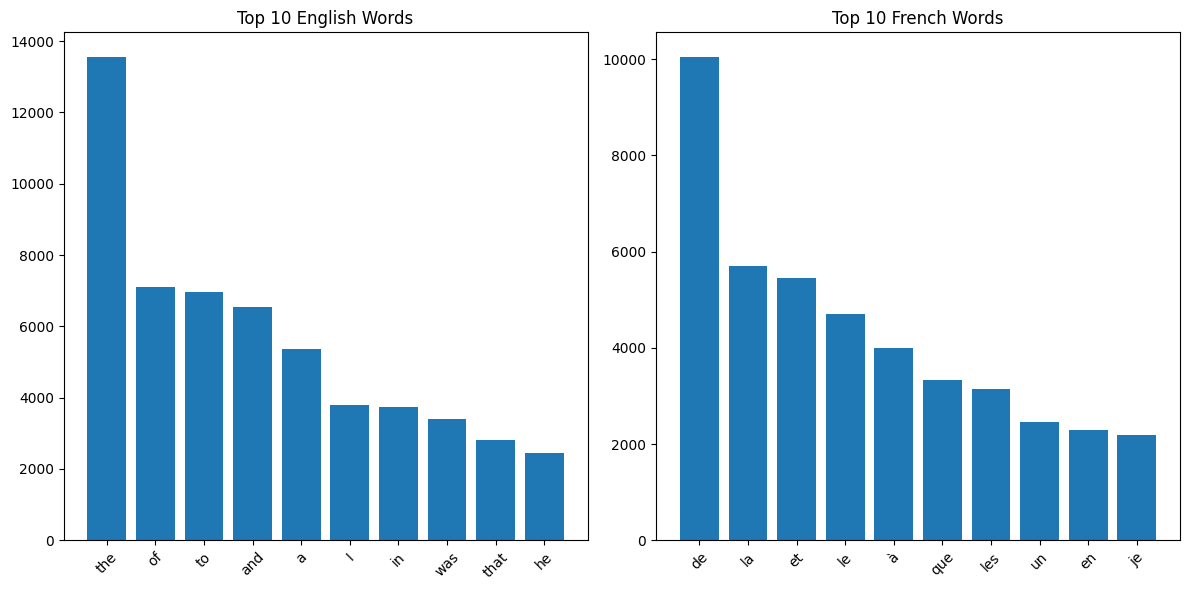

Vocabulary size for English: 38705
Vocabulary size for French: 44378


In [ ]:
from collections import Counter

en_words = ' '.join(df['en']).split()
fr_words = ' '.join(df['fr']).split()


en_word_freq = Counter(en_words)
fr_word_freq = Counter(fr_words)

print("Most common English words:", en_word_freq.most_common(10))
print("Most common French words:", fr_word_freq.most_common(10))

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.bar(*zip(*en_word_freq.most_common(10)))
plt.title('Top 10 English Words')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(*zip(*fr_word_freq.most_common(10)))
plt.title('Top 10 French Words')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"Vocabulary size for English: {len(set(en_words))}")
print(f"Vocabulary size for French: {len(set(fr_words))}")


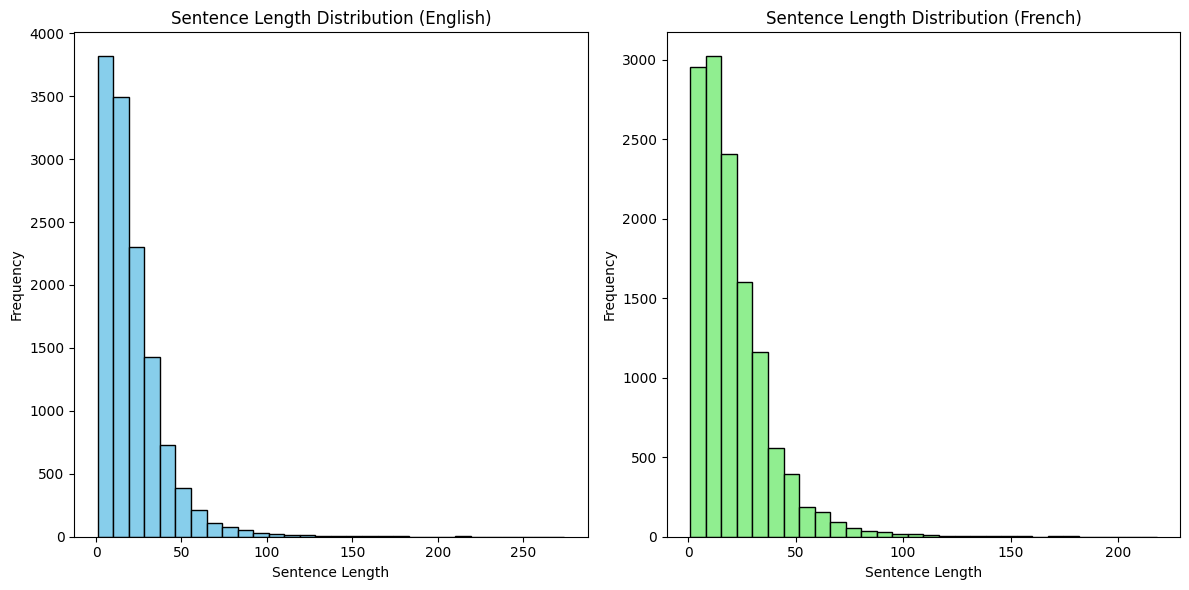

In [ ]:

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.hist(df['en_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Sentence Length Distribution (English)')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist(df['fr_length'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Sentence Length Distribution (French)')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:

def find_outliers(lengths):
    Q1 = lengths.quantile(0.25)
    Q3 = lengths.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lengths[(lengths < lower_bound) | (lengths > upper_bound)]

en_outliers = find_outliers(df['en_length'])
fr_outliers = find_outliers(df['fr_length'])

print(f"English sentence outliers: {en_outliers}")
print(f"French sentence outliers: {fr_outliers}")


English sentence outliers: 6         92
35        68
123       92
166       76
182       66
        ... 
12529     83
12579     57
12603     58
12604     81
12628    179
Name: en_length, Length: 525, dtype: int64
French sentence outliers: 35        59
123       90
166       68
182       64
183       83
        ... 
12513     64
12542     55
12603     56
12604     58
12628    160
Name: fr_length, Length: 526, dtype: int64


English sentence outliers: 6         92
35        68
123       92
166       76
182       66
        ... 
12529     83
12579     57
12603     58
12604     81
12628    179
Name: en_length, Length: 525, dtype: int64
French sentence outliers: 35        59
123       90
166       68
182       64
183       83
        ... 
12513     64
12542     55
12603     56
12604     58
12628    160
Name: fr_length, Length: 526, dtype: int64


<ipython-input-16-31666b7f39c3>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sentence Type', y='Length', data=lengths_data, palette='Set2')


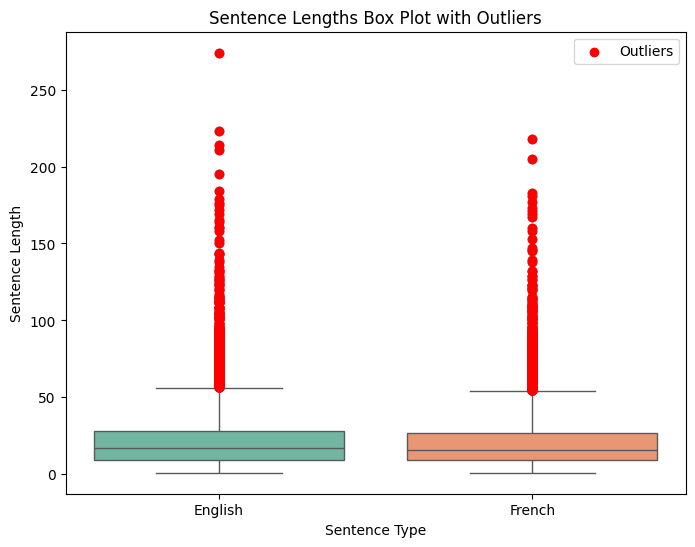

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def find_outliers(lengths):
    Q1 = lengths.quantile(0.25)
    Q3 = lengths.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lengths[(lengths < lower_bound) | (lengths > upper_bound)]


en_outliers = find_outliers(df['en_length'])
fr_outliers = find_outliers(df['fr_length'])


print(f"English sentence outliers: {en_outliers}")
print(f"French sentence outliers: {fr_outliers}")

lengths_data = pd.DataFrame({
    'Sentence Type': ['English'] * len(df['en_length']) + ['French'] * len(df['fr_length']),
    'Length': list(df['en_length']) + list(df['fr_length'])
})


plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentence Type', y='Length', data=lengths_data, palette='Set2')


outliers = pd.concat([en_outliers, fr_outliers])
plt.scatter([0] * len(en_outliers) + [1] * len(fr_outliers),
            outliers, color='red', label='Outliers', zorder=3)

plt.title('Sentence Lengths Box Plot with Outliers')
plt.xlabel('Sentence Type')
plt.ylabel('Sentence Length')


plt.legend()
plt.show()


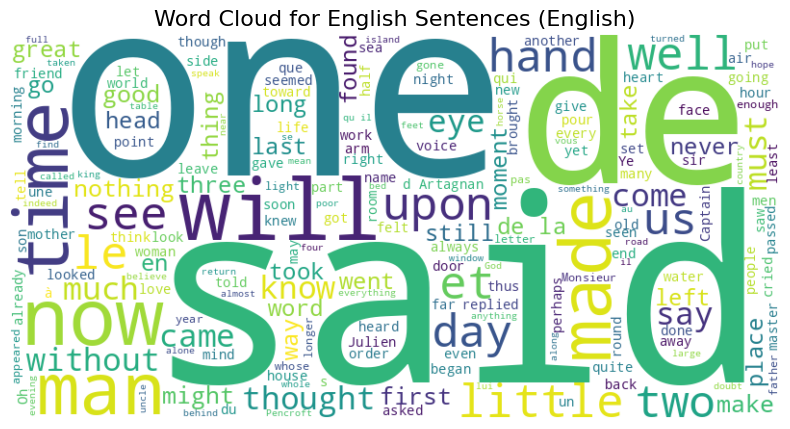

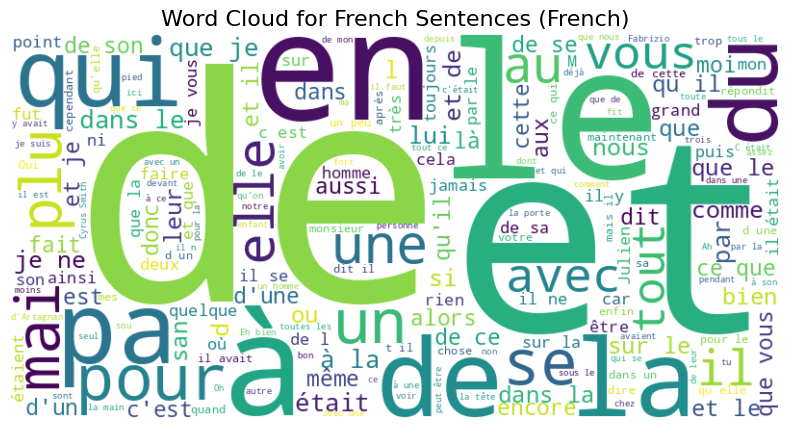

In [ ]:
# Generate word clouds for English and French
def plot_wordcloud(text, title, language):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {title} ({language})", fontsize=16)
    plt.show()

plot_wordcloud(df['en'], 'English Sentences', 'English')
plot_wordcloud(df['fr'], 'French Sentences', 'French')


In [ ]:

df_filtered = df[(df['en_length'] <= 50) & (df['fr_length'] <= 50)]


filtered_sentences = len(df_filtered)
print(f"Total number of sentence pairs after filtering: {filtered_sentences}")


new_avg_en_length = df_filtered['en_length'].mean()
new_avg_fr_length = df_filtered['fr_length'].mean()

print(f"Average English sentence length after filtering: {new_avg_en_length}")
print(f"Average French sentence length after filtering: {new_avg_fr_length}")


Total number of sentence pairs after filtering: 11878
Average English sentence length after filtering: 17.924313857551777
Average French sentence length after filtering: 17.58999831621485


n-grams

In [ ]:

def generate_ngrams(text_series, n):
    ngrams_list = [ngrams(sentence.split(), n) for sentence in text_series]
    ngrams_flat = [gram for sentence in ngrams_list for gram in sentence]
    return Counter(ngrams_flat)
bigrams_en = generate_ngrams(df['en'], 2)
bigrams_fr = generate_ngrams(df['fr'], 2)

print("Top 10 English Bigrams:", bigrams_en.most_common(10))
print("Top 10 French Bigrams:", bigrams_fr.most_common(10))


Top 10 English Bigrams: [(('of', 'the'), 1797), (('in', 'the'), 1051), (('to', 'the'), 792), (('at', 'the'), 503), (('on', 'the'), 482), (('and', 'the'), 463), (('to', 'be'), 432), (('of', 'a'), 375), (('in', 'a'), 366), (('it', 'was'), 333)]
Top 10 French Bigrams: [(('de', 'la'), 1135), (('que', 'je'), 493), (('à', 'la'), 470), (('dans', 'la'), 352), (('et', 'de'), 321), (('je', 'ne'), 319), (('dans', 'le'), 274), (('de', 'son'), 264), (('et', 'je'), 235), (('que', 'vous'), 232)]


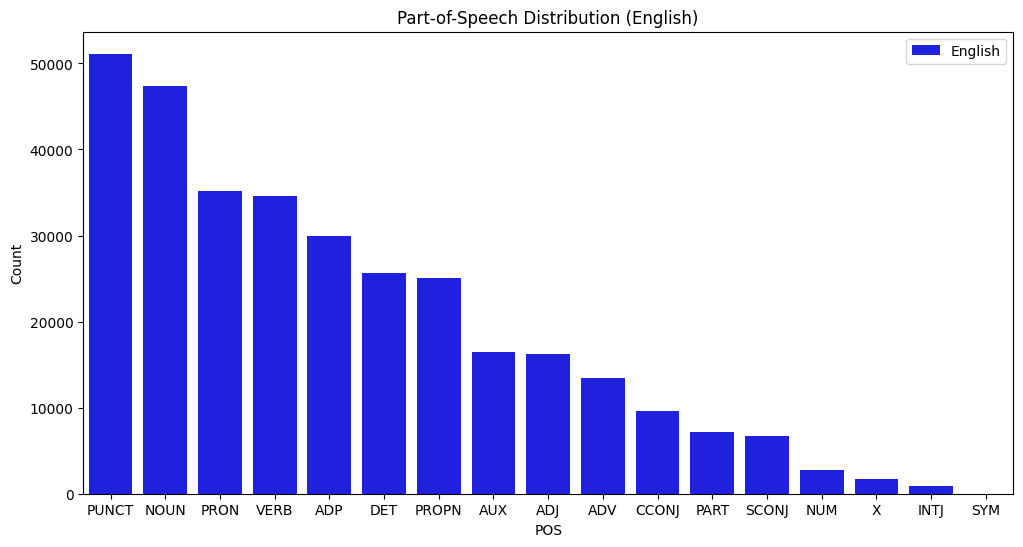

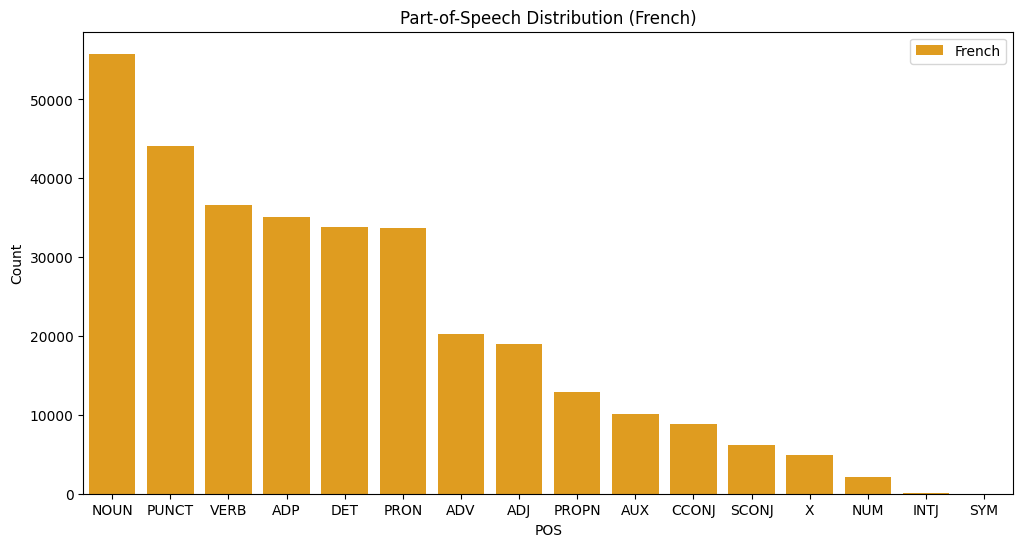

In [ ]:
# POS tagging using spaCy
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_sm")
def pos_distribution(text_series, nlp_model):
    pos_counts = Counter([token.pos_ for sentence in text_series for token in nlp_model(sentence)])
    return pd.DataFrame(pos_counts.items(), columns=["POS", "Count"]).sort_values(by="Count", ascending=False)

pos_en = pos_distribution(df['en'], nlp_en)
pos_fr = pos_distribution(df['fr'], nlp_fr)

plt.figure(figsize=(12, 6))
sns.barplot(data=pos_en, x="POS", y="Count", color='blue', label='English')
plt.title("Part-of-Speech Distribution (English)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=pos_fr, x="POS", y="Count", color='orange', label='French')
plt.title("Part-of-Speech Distribution (French)")
plt.show()


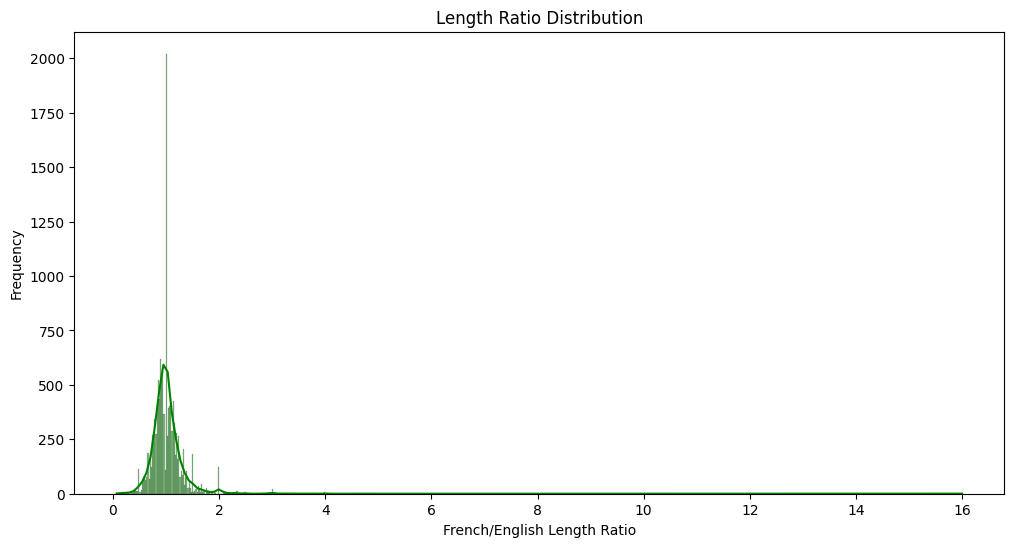

In [ ]:
# Calculate and plot length ratio
df['length_ratio'] = df['fr_length'] / df['en_length']

plt.figure(figsize=(12, 6))
sns.histplot(df['length_ratio'], kde=True, color='green')
plt.xlabel("French/English Length Ratio")
plt.ylabel("Frequency")
plt.title("Length Ratio Distribution")
plt.show()


Data Cleaning

In [ ]:

duplicates = df[df.duplicated(subset=['en', 'fr'], keep=False)]
print(f"Number of duplicate pairs: {len(duplicates)}")

df = df.drop_duplicates(subset=['en', 'fr'], keep='first')
print(f"Number of rows after removing duplicates: {len(df)}")



Number of duplicate pairs: 34
Number of rows after removing duplicates: 12688


In [ ]:

def clean_text(text, language="en"):
    text = str(text)
    if "<" in text and ">" in text:
        text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"[''`]", "'", text)
    text = re.sub(r"[–—]", "-", text)
    if language == "en":
        text = contractions.fix(text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

df['en_clean'] = df['en'].apply(lambda x: clean_text(x, language="en"))
df['fr_clean'] = df['fr'].apply(lambda x: clean_text(x, language="fr"))

In [ ]:
import re
import string
import contractions
from bs4 import BeautifulSoup


def clean_text(text, language="en"):

    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"[’‘`]", "'", text)
    text = re.sub(r"[–—]", "-", text)
    if language == "en":
        text = contractions.fix(text)

    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    return text

df['en_clean'] = df['en'].apply(lambda x: clean_text(x, language="en"))
df['fr_clean'] = df['fr'].apply(lambda x: clean_text(x, language="fr"))


<ipython-input-24-0dff98bdf1b6>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
# Convert to lowercase
df['en_clean'] = df['en_clean'].str.lower()
df['fr_clean'] = df['fr_clean'].str.lower()


In [ ]:
# Tokenization function using SentencePiece
def train_sentencepiece(data, vocab_size=8000, model_prefix="sp_model"):
    with open("temp_data.txt", "w") as f:
        for text in data:
            f.write(text + "\n")
    spm.SentencePieceTrainer.train(f'--input=temp_data.txt --model_prefix={model_prefix} --vocab_size={vocab_size} --character_coverage=1.0 --model_type=bpe')
    return spm.SentencePieceProcessor(model_file=f"{model_prefix}.model")

en_tokenizer = train_sentencepiece(df['en_clean'].tolist())
fr_tokenizer = train_sentencepiece(df['fr_clean'].tolist())


df['en_tokens'] = df['en_clean'].apply(lambda x: en_tokenizer.encode(x))
df['fr_tokens'] = df['fr_clean'].apply(lambda x: fr_tokenizer.encode(x))

In [ ]:

def build_vocab(tokens_list, vocab_size=45000):
    all_tokens = [token for sentence in tokens_list for token in sentence]
    token_counts = Counter(all_tokens)
    vocab = {token: idx for idx, (token, _) in enumerate(token_counts.most_common(vocab_size), start=1)}
    vocab['<UNK>'] = 0
    return vocab

en_vocab = build_vocab(df['en_tokens'], vocab_size=45000)
fr_vocab = build_vocab(df['fr_tokens'], vocab_size=45000)

In [ ]:

def encode_text(tokens, vocab):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

df['en_encoded'] = df['en_tokens'].apply(lambda x: encode_text(x, en_vocab))
df['fr_encoded'] = df['fr_tokens'].apply(lambda x: encode_text(x, fr_vocab))

In [ ]:
# Padding
max_len = 50

def pad_sequences_fn(tokens, max_len=max_len):
    return pad_sequences([tokens], maxlen=max_len, padding='post', truncating='post')[0]

df['en_padded'] = df['en_encoded'].apply(lambda x: pad_sequences_fn(x))
df['fr_padded'] = df['fr_encoded'].apply(lambda x: pad_sequences_fn(x))

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df['en_padded'], df['fr_padded'], test_size=0.2, random_state=42)

Hidden Markov Model

In [ ]:
opus_data = opus_dataset["train"].train_test_split(test_size=0.001, seed=7)["test"]

print(f"Total original dataset size: {len(opus_dataset['train'])}")
print(f"Sampled dataset size: {len(opus_data)}")
df = pd.DataFrame(opus_data)

# Extract 'en' and 'fr' from the 'translation' column
df['en'] = df['translation'].apply(lambda x: x['en'])
df['fr'] = df['translation'].apply(lambda x: x['fr'])

# Drop the original 'translation' column
df = df.drop(columns=['translation'])

Total original dataset size: 127085
Sampled dataset size: 128


In [ ]:
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split



df['en_tokens'] = df['en'].apply(lambda x: x.split())
df['fr_tokens'] = df['fr'].apply(lambda x: x.split())


en_vocab = set([word for sentence in df['en_tokens'] for word in sentence])
fr_vocab = set([word for sentence in df['fr_tokens'] for word in sentence])


en_encoder = LabelEncoder()
fr_encoder = LabelEncoder()


en_encoder.fit(list(en_vocab))
fr_encoder.fit(list(fr_vocab))

df['en_encoded'] = df['en_tokens'].apply(lambda x: en_encoder.transform(x))
df['fr_encoded'] = df['fr_tokens'].apply(lambda x: fr_encoder.transform(x))


observations = np.concatenate(df['en_encoded'].values)
states = np.concatenate(df['fr_encoded'].values)
lengths = [len(seq) for seq in df['en_encoded']]


model = hmm.MultinomialHMM(n_components= 14, n_iter=100)
X = observations.reshape(-1, 1)
model.fit(X, lengths=lengths)

test_size = int(0.9 * len(df))
test_df = df.sample(test_size, random_state=72)


test_observations = np.concatenate(test_df['en_encoded'].values)
test_lengths = [len(seq) for seq in test_df['en_encoded']]


X_test = test_observations.reshape(-1, 1)
predicted_states = model.predict(X_test)


predicted_french_tokens = fr_encoder.inverse_transform(predicted_states)
actual_french_tokens = np.concatenate(test_df['fr_encoded'].values)


predicted_french_sentences = [' '.join(predicted_french_tokens[i:i+length])
                              for i, length in zip(np.cumsum(test_lengths[:-1]), test_lengths)]
actual_french_sentences = [' '.join(fr_encoder.inverse_transform(actual_french_tokens[i:i+length]))
                           for i, length in zip(np.cumsum(test_lengths[:-1]), test_lengths)]

bleu_scores = [sentence_bleu([actual.split()], predicted.split()) for actual, predicted in zip(actual_french_sentences, predicted_french_sentences)]
average_bleu_score = np.mean(bleu_scores)
print(f"Average BLEU score: {average_bleu_score}")


# Printing the transition matrix
transition_matrix = model.transmat_

# Convert the transition matrix into a pandas DataFrame for better readability
transition_df = pd.DataFrame(transition_matrix, index=[f"State {i}" for i in range(transition_matrix.shape[0])],
                              columns=[f"State {i}" for i in range(transition_matrix.shape[1])])

print("\nTransition Matrix B (State to State Transition Probabilities):")
print(transition_df)

Long Short Term Memory(LSTM)

In [ ]:
opus_data = opus_dataset["train"].train_test_split(test_size=0.001, seed=7)["test"]
df = pd.DataFrame(opus_data)

df['en'] = df['translation'].apply(lambda x: x['en'])
df['fr'] = df['translation'].apply(lambda x: x['fr'])

df = df.drop(columns=['translation'])

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(df['en'])
vocab_size_en = len(tokenizer_en.word_index) + 1

tokenizer_fr = Tokenizer()
tokenizer_fr.fit_on_texts(df['fr'])
vocab_size_fr = len(tokenizer_fr.word_index) + 1

X = tokenizer_en.texts_to_sequences(df['en'])
y = tokenizer_fr.texts_to_sequences(df['fr'])

max_input_length = max([len(seq) for seq in X])
max_output_length = max([len(seq) for seq in y])

X = pad_sequences(X, maxlen=max_input_length, padding='post')
y = pad_sequences(y, maxlen=max_output_length, padding='post')

y_input = y[:, :-1]
y_output = y[:, 1:]

embedding_dim = 128
hidden_units = 256


encoder_input = Input(shape=(max_input_length,))
encoder_embedding = Embedding(vocab_size_en, embedding_dim)(encoder_input)
encoder_lstm, forward_h, forward_c = LSTM(hidden_units, return_state=True)(encoder_embedding)
encoder_states = [forward_h, forward_c]

decoder_input = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(vocab_size_fr, embedding_dim)(decoder_input)
decoder_lstm = LSTM(hidden_units, return_sequences=True)(decoder_embedding, initial_state=encoder_states)
decoder_output = Dense(vocab_size_fr, activation='softmax')(decoder_lstm)

model = Model([encoder_input, decoder_input], decoder_output)


model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit([X, y_input], np.expand_dims(y_output, -1), epochs=20, batch_size=64, validation_split=0.2)

model.summary()

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.2038 - loss: 6.9593 - val_accuracy: 0.7885 - val_loss: 6.5256
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8191 - loss: 6.3442 - val_accuracy: 0.7885 - val_loss: 5.0243
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8207 - loss: 4.7171 - val_accuracy: 0.7885 - val_loss: 3.3598
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8207 - loss: 3.0518 - val_accuracy: 0.7885 - val_loss: 2.2617
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8262 - loss: 1.9444 - val_accuracy: 0.7885 - val_loss: 1.8086
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8171 - loss: 1.5626 - val_accuracy: 0.7885 - val_loss: 1.7912
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8187 - loss: 1.5031 - val_accuracy: 0.7885 - val_loss: 1.8291
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8183 - loss: 1.5032 - val_accuracy: 0.7885 - val_loss: 1.8115
Epoch 9/20
2/2 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 89)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 90)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 89, 128)        │        136,704 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 90, 128)        │        140,800 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 256), (None,   │        394,240 │ embedding_6[0][0]      │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 90, 256)        │        394,240 │ embedding_7[0][0],     │
│                           │                        │                │ lstm_6[0][1],          │
│                           │                        │                │ lstm_6[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 90, 1100)       │        282,700 │ lstm_7[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,046,054 (15.43 MB)

 Trainable params: 1,348,684 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,697,370 (10.29 MB)

In [ ]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.preprocessing.sequence import pad_sequences


subset_df = df.sample(frac=0.2, random_state=7)


X_subset = tokenizer_en.texts_to_sequences(subset_df['en'])
y_subset = tokenizer_fr.texts_to_sequences(subset_df['fr'])


encoder_input_length = model.inputs[0].shape[1]
decoder_input_length = model.inputs[1].shape[1]


X_subset_padded = pad_sequences(X_subset, maxlen=encoder_input_length, padding='post')
y_subset_padded = pad_sequences(y_subset, maxlen=max_output_length, padding='post')

def generate_translation(input_seq):
    input_seq = np.expand_dims(input_seq, axis=0)
    target_seq = np.zeros((1, decoder_input_length))
    decoded_sentence = []
    for i in range(decoder_input_length):
        output = model.predict([input_seq, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, i, :])
        decoded_sentence.append(sampled_token_index)

        if sampled_token_index == 0:
            break

        if i < decoder_input_length - 1:
            target_seq[0, i+1] = sampled_token_index

    return decoded_sentence


bleu_scores = []
for i in range(len(X_subset_padded)):
    input_seq = X_subset_padded[i]
    actual_seq = y_subset_padded[i]

    predicted_seq = generate_translation(input_seq)
    actual_text = tokenizer_fr.sequences_to_texts([actual_seq])[0]
    predicted_text = tokenizer_fr.sequences_to_texts([predicted_seq])[0]
    bleu = sentence_bleu([actual_text.split()], predicted_text.split())
    bleu_scores.append(bleu)
    if i < 5:
        print(f"\nExample {i+1}:")
        print(f"English: {subset_df['en'].iloc[i]}")
        print(f"Actual French: {actual_text}")
        print(f"Predicted French: {predicted_text}")
        print(f"BLEU Score: {bleu:.4f}")

average_bleu = np.mean(bleu_scores)
print(f"\nAverage BLEU Score: {average_bleu:.4f}")

Transformer

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
from datasets import Dataset
from transformers import TrainingArguments, Trainer
from nltk.translate.bleu_score import corpus_bleu
import torch

model_name = "Helsinki-NLP/opus-mt-en-fr"


tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


train_texts = X_train.tolist()
val_texts = X_test.tolist()
train_labels = y_train.tolist()
val_labels = y_test.tolist()

train_dataset = Dataset.from_dict({"en": train_texts, "fr": train_labels})
val_dataset = Dataset.from_dict({"en": val_texts, "fr": val_labels})

train_dataset = train_dataset.select(range(500))
val_dataset = val_dataset.select(range(250))


def tokenize_function(examples):

    inputs = {"input_ids": examples["en"], "attention_mask": [[1] * len(seq) for seq in examples["en"]]}
    targets = {"input_ids": examples["fr"], "attention_mask": [[1] * len(seq) for seq in examples["fr"]]}


    inputs["labels"] = targets["input_ids"]
    return inputs


train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    save_steps=10_000,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True,
    fp16=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)


trainer.train()


trainer.save_model("./marianmt_finetuned")
tokenizer.save_pretrained("./marianmt_finetuned")


def generate_translation(text):

    if isinstance(text, list):
        text = ' '.join(text)


    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=30).to(device)


    forced_bos_token_id = tokenizer.encode("<2-fr>", add_special_tokens=False)[0]


    translated = model.generate(**inputs, forced_bos_token_id=forced_bos_token_id)

    return tokenizer.decode(translated[0], skip_special_tokens=True)


predictions = []
references = []



In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


def calculate_bleu_score(predictions, references):

    references = [[tokenizer.decode(ref, skip_special_tokens=True).split()] for ref in references]
    predictions = [pred.split() for pred in predictions]


    smoothing_function = SmoothingFunction().method4
    return corpus_bleu(references, predictions, smoothing_function=smoothing_function)


predictions = []
references = []


for example in val_dataset:
    source_text = example["en"]
    target_text = example["fr"]

    if isinstance(source_text, list):
        source_text = tokenizer.decode(source_text, skip_special_tokens=True)

    translation = generate_translation(source_text)
    predictions.append(translation)

    references.append(target_text)


bleu_score = calculate_bleu_score(predictions, references)
print(f"BLEU Score: {bleu_score:.4f}")